In [1]:
import warnings

# Ignore future warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import scanpy as sc
import scvi
import scib
from tqdm import tqdm

# Set global matplotlib figure size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

# Ignore future warnings
warnings.filterwarnings("ignore")

In [2]:
outdir = "figures/integration"
os.makedirs(outdir, exist_ok=True)

In [3]:
adata = sc.read_h5ad("1_qc.h5ad")
adata

AnnData object with n_obs × n_vars = 10903 × 29620
    obs: 'sample', 'sample_type', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample_group', 'facs_day'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'scrublet'
    layers: 'ambiguous', 'count', 'log1p', 'spliced', 'unspliced'

In [4]:
# Specify which colorings to use for plotting
umap_colorings = [
    "sample",
    "cell_type",
    "facs_day"
]

# Data preparation

In [5]:
# For now, we ignore RR cells
# They have a different gene expression profile
# Not sure how to deal with them yet (and what we want to learn from them)
adata = adata[adata.obs["sample_group"].notnull()].copy()
sample_types = adata.obs["sample_type"].unique()

type_adata = {
    sample_type: adata[adata.obs["sample_type"] == sample_type].copy()
    for sample_type in sample_types
}

type_hvg = {}

for sample_type, adata in type_adata.items():
    sc.pp.highly_variable_genes(adata, n_top_genes=5000, batch_key="sample", layer="log1p")
    type_hvg[sample_type] = adata[:, adata.var.highly_variable].copy()

## Looking at the uncorrected data distributions

In [6]:
unintegrated_dir = os.path.join(outdir, "unintegrated")
for sample_type, adata in tqdm(type_adata.items()):
    sample_dir = os.path.join(unintegrated_dir, sample_type)
    os.makedirs(sample_dir, exist_ok=True)
    sc.pp.pca(adata, n_comps=50, layer="log1p")
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    for coloring in umap_colorings:
        fig, ax = plt.subplots()
        sc.pl.umap(adata, color=coloring, title=f"Uncorrected {sample_type}", ax=ax, show=False)
        fig.tight_layout()
        fig.savefig(os.path.join(sample_dir, f"umap_{coloring}.png"))
        plt.close(fig)

100%|██████████| 3/3 [00:19<00:00,  6.47s/it]


We can see that the samples form clusters in the UMAP. This indicates that the batch effects are not negligible.
We can also see that the cell types separate in the UMAP. 
Biological signal and batch effects appear to be of similar strength in this data.

# Integration

Batch correction is referred to as integration in the single-cell literature. This is, because the count matrices are too large for performing actual batch correction. Instead, the data is integrated into a lower-dimensional space, where the batch effects are removed.

## scVI

scVI uses a variational Autoencoder to integrate the data. The encoder learns a lower-dimensional representation of the data, while the decoder learns to reconstruct the data from this representation.

In [11]:
scvi_dir = os.path.join(outdir, "scvi")
for sample_type, adata in tqdm(type_hvg.items()):
    print(f"Running scVI for {sample_type}")
    sample_dir = os.path.join(scvi_dir, sample_type)
    os.makedirs(sample_dir, exist_ok=True)
    scvi.model.SCVI.setup_anndata(adata, batch_key="sample", layer="count", categorical_covariate_keys=["facs_day"])
    model = scvi.model.SCVI(adata)
    model.train(max_epochs=400, accelerator='cuda', early_stopping=True, datasplitter_kwargs={"drop_last": True})

    adata.obsm["X_scvi"] = model.get_latent_representation()

    # Plot the UMAP based on the scVI latent space
    sc.pp.neighbors(adata, use_rep="X_scvi")
    sc.tl.umap(adata)
    adata.obsm["X_umap_scvi"] = adata.obsm["X_umap"].copy()

    for coloring in umap_colorings:
        fig, ax = plt.subplots()
        sc.pl.umap(adata, color=coloring, title=f"scVI {sample_type}", ax=ax, show=False)
        fig.tight_layout()
        fig.savefig(os.path.join(sample_dir, f"umap_{coloring}.png"))
        plt.close(fig)

  0%|          | 0/3 [00:00<?, ?it/s]Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Running scVI for rr_incl


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1628.671. Signaling Trainer to stop.


 33%|███▎      | 1/3 [00:55<01:50, 55.35s/it]Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Running scVI for combined


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2548.552. Signaling Trainer to stop.


 67%|██████▋   | 2/3 [02:04<01:03, 63.23s/it]Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Running scVI for rr_depl


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2407.475. Signaling Trainer to stop.


100%|██████████| 3/3 [03:29<00:00, 69.80s/it]


While the cell types still separate in the UMAP, the batch effects are removed. This indicates that scVI has successfully integrated the data.
However it looks overcorrected, as subpopulations are not as clearly separated as in the uncorrected data.

## Harmony

Harmony receives a PCA representation of the data and removes the batch effects from there.
Benchmarks have shown that Harmony is one of the best batch correction methods for single-cell data.

In [8]:
harmony_dir = os.path.join(outdir, "harmony")

for sample_type, adata in tqdm(type_adata.items()):
    print(f"Running Harmony for {sample_type}")
    sample_dir = os.path.join(harmony_dir, sample_type)
    os.makedirs(sample_dir, exist_ok=True)

    sc.external.pp.harmony_integrate(adata, "sample", max_iter_harmony=50)

    sc.pp.neighbors(adata, use_rep="X_pca_harmony")
    sc.tl.umap(adata)
    adata.obsm["X_umap_harmony"] = adata.obsm["X_umap"].copy()

    for coloring in umap_colorings:
        fig, ax = plt.subplots()
        sc.pl.umap(adata, color=coloring, title=f"Harmony {sample_type}", ax=ax, show=False)
        fig.tight_layout()
        fig.savefig(os.path.join(sample_dir, f"umap_{coloring}.png"))
        plt.close(fig)

  0%|          | 0/3 [00:00<?, ?it/s]2025-01-22 11:18:24,191 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony for rr_incl


2025-01-22 11:18:24,393 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-22 11:18:24,398 - harmonypy - INFO - Iteration 1 of 50
2025-01-22 11:18:24,832 - harmonypy - INFO - Iteration 2 of 50
2025-01-22 11:18:25,197 - harmonypy - INFO - Iteration 3 of 50
2025-01-22 11:18:25,534 - harmonypy - INFO - Iteration 4 of 50
2025-01-22 11:18:25,937 - harmonypy - INFO - Iteration 5 of 50
2025-01-22 11:18:26,320 - harmonypy - INFO - Converged after 5 iterations
 33%|███▎      | 1/3 [00:05<00:10,  5.22s/it]2025-01-22 11:18:29,407 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony for combined


2025-01-22 11:18:29,751 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-22 11:18:29,759 - harmonypy - INFO - Iteration 1 of 50
2025-01-22 11:18:30,472 - harmonypy - INFO - Iteration 2 of 50
2025-01-22 11:18:31,131 - harmonypy - INFO - Iteration 3 of 50
2025-01-22 11:18:31,766 - harmonypy - INFO - Iteration 4 of 50
2025-01-22 11:18:32,457 - harmonypy - INFO - Iteration 5 of 50
2025-01-22 11:18:33,120 - harmonypy - INFO - Iteration 6 of 50
2025-01-22 11:18:33,433 - harmonypy - INFO - Converged after 6 iterations
 67%|██████▋   | 2/3 [00:12<00:06,  6.61s/it]2025-01-22 11:18:36,984 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony for rr_depl


2025-01-22 11:18:37,283 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-22 11:18:37,291 - harmonypy - INFO - Iteration 1 of 50
2025-01-22 11:18:37,939 - harmonypy - INFO - Iteration 2 of 50
2025-01-22 11:18:38,508 - harmonypy - INFO - Iteration 3 of 50
2025-01-22 11:18:39,110 - harmonypy - INFO - Iteration 4 of 50
2025-01-22 11:18:39,734 - harmonypy - INFO - Iteration 5 of 50
2025-01-22 11:18:40,304 - harmonypy - INFO - Iteration 6 of 50
2025-01-22 11:18:40,666 - harmonypy - INFO - Iteration 7 of 50
2025-01-22 11:18:40,967 - harmonypy - INFO - Iteration 8 of 50
2025-01-22 11:18:41,255 - harmonypy - INFO - Iteration 9 of 50
2025-01-22 11:18:41,542 - harmonypy - INFO - Converged after 9 iterations
100%|██████████| 3/3 [00:20<00:00,  6.94s/it]


Here, cell types also separate in the UMAP. Some samples are still clustered, but the batch effects are mostly removed.
This is probably a good compromise between removing batch effects and keeping the biological signal.

# Integration benchmarking using scIB

In [9]:
embeddings = ["X_scvi", "X_pca_harmony"]

results = []

for embedding in embeddings:
    result = scib.me.metrics(adata.raw.to_adata(),
        adata,
        "sample",
        "cell_type",
        embed=embedding,
        organism='mouse',
        ari_=True,
        nmi_=True,
        silhouette_=True,
        pcr_=False,
        cell_cycle_=False,
        hvg_score_=False,
        isolated_labels_=True,
        graph_conn_=True,
        trajectory_=False,
        kBET_=False,
        lisi_graph_=True
    )

    result.columns = [embedding]
    results.append(result)

Recompute neighbors on rep X_scvi instead of X_pca_harmony


ValueError: Did not find X_scvi in `.obsm.keys()`. You need to compute it first.

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<Axes: >

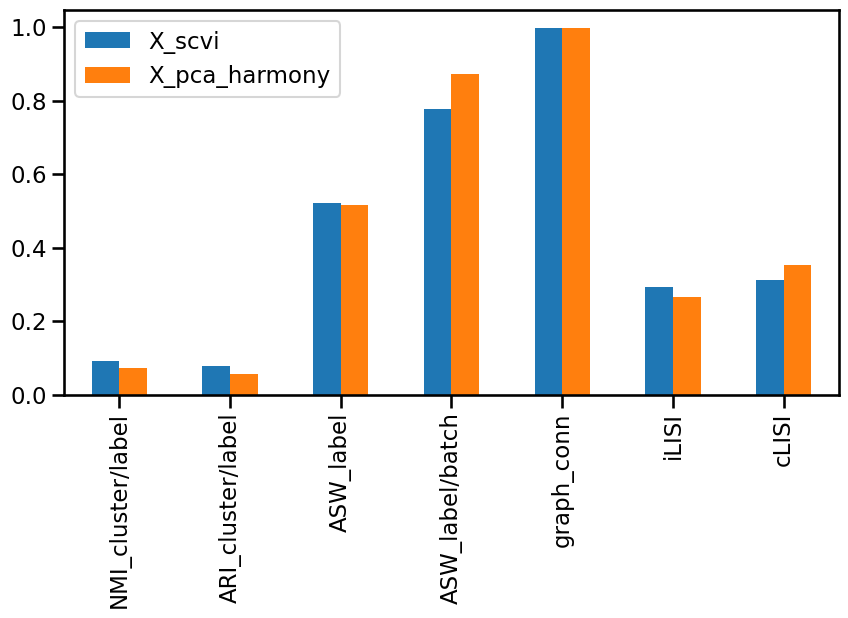

In [ ]:
df_scib = pd.concat(results, axis=1)
df_scib.dropna(axis=0, how='all', inplace=True)
df_scib.plot(kind='bar', figsize=(10, 5))

# Save the data

In [14]:
adata

AnnData object with n_obs × n_vars = 5195 × 27451
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'cluster_0.2', 'cluster_0.4', 'cluster_0.6', 'cluster_0.8', 'cluster_1.0', 'cluster_1.2', 'cluster_1.4', 'cluster_1.6', 'cluster_1.8', 'cluster_2.0', 'cluster', 'silhouette_temp'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'scrublet

In [15]:
adata.write("2_integrate.h5ad")

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
